## 1. Import Standard Libraries

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [4]:
mnist = pd.read_csv("Mnist_combined.csv" ,index_col= 0)

In [5]:
mnist.head(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.tail(3)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9999,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. A function that returns a dataset with a specified size

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from torch.utils.data import DataLoader,TensorDataset

In [9]:
# import dataset 
mnist_np = mnist.to_numpy()

# Now for the function
def makeTheDataset(dataFull,N,doubleTheData=False):

    # extract labels (number IDs) and remove from data
    labels = dataFull[:N,0]
    data   = dataFull[:N,1:]

    # normalize the data to a range of [0 1]
    dataNorm = data / (np.max(data)-np.min(data))

    # make an exact copy of ALL the data
#     if doubleTheData:
#         dataNorm = np.concatenate((dataNorm,dataNorm),axis=0)
#         labels   = np.concatenate((labels,labels),axis=0)


    # convert to tensor
    dataT   = torch.tensor( dataNorm ).float()
    labelsT = torch.tensor( labels ).long()

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, 
                                                                      test_size=0.1)


    # Make an exact copy of the TRAIN data
    if doubleTheData:
        train_data   = torch.cat((train_data,train_data),axis=0)
        train_labels = torch.cat((train_labels,train_labels),axis=0)


    # Convert into PyTorch Datasets
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)

    # translate into dataloader objects
    batchsize    = 25
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    return train_loader,test_loader

In [10]:
# Check the sizes

train_loader_test,test_loader_test = makeTheDataset(dataFull=mnist_np, N=200, doubleTheData=False)
print(train_loader_test.dataset.tensors[0].shape)
print(test_loader_test.dataset.tensors[0].shape)

train_loader_testd,test_loader_testd = makeTheDataset(dataFull=mnist_np, N=200, doubleTheData=True)
print(train_loader_testd.dataset.tensors[0].shape)
print(test_loader_testd.dataset.tensors[0].shape)

torch.Size([180, 784])
torch.Size([20, 784])
torch.Size([360, 784])
torch.Size([20, 784])


## 4. Create ANN Model

In [14]:
# create a class for the model
def createTheMNISTNet(LR):

    class MNISTNet(nn.Module):
        
        def __init__(self):
            
            super().__init__()

            ### input layer
            self.input = nn.Linear(784,64)

            ### hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            ### output layer
            self.output = nn.Linear(32,10)

        # forward pass
        def forward(self,x):

            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )

            return self.output(x)
  
    # create the model instance
    ANN_model = MNISTNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR)

    return ANN_model,lossfunc,optimizer

## 5. Model Training

In [15]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , test_loader , epochs):

    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []
    
    # loop over epochs
    for epochi in range(epochs):
         
        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()                   # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric)       # average and x100 
            batchAcc.append( accuracyPct )                     # add to list of accuracies
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # End epochs

    # function output
    return trainAcc,testAcc,losses,Model

## 6. Parametric Study

In [16]:
# Takes ~10 mins

# list of data sample sizes
samplesizes = np.arange(500,4001,500)

# initialize results matrix : for storing train_acc, test_acc, loss
resultsSingle = np.zeros((len(samplesizes),3))
resultsDouble = np.zeros((len(samplesizes),3))


for idx,s_size in enumerate(samplesizes):

    ### without doubling the data!
    ANN_model1,Lossfunc1,Optimizer1 = createTheMNISTNet(LR=0.01)
    
    # generate a dataset and 
    train_loader1,test_loader1 = makeTheDataset(dataFull=mnist_np, N=s_size, doubleTheData=False)
    
    # train the model : 
    TrainAcc1,TestAcc1,Losses1,trained_Model1 = function2trainTheModel(Model=ANN_model1,
                                                        lossfunc=Lossfunc1,
                                                        optimizer=Optimizer1,
                                                        train_loader=train_loader1,
                                                        test_loader=test_loader1,
                                                        epochs=50 )
    
    # grab the results
    resultsSingle[idx,0] = np.mean(TrainAcc1[-5:])
    resultsSingle[idx,1] = np.mean(TestAcc1[-5:])
    resultsSingle[idx,2] = torch.mean(Losses1[-5:]).item()


    ### with doubling the data!
    ANN_model2,Lossfunc2,Optimizer2 = createTheMNISTNet(LR=0.01)
    # generate a dataset and 
    train_loader2,test_loader2 = makeTheDataset(dataFull=mnist_np, N=s_size, doubleTheData=True)
   
    # train the model : 
    TrainAcc2,TestAcc2,Losses2,trained_Model2= function2trainTheModel(Model=ANN_model2,
                                                        lossfunc=Lossfunc2,
                                                        optimizer=Optimizer2,
                                                        train_loader=train_loader2,
                                                        test_loader=test_loader2,
                                                        epochs=50 )
    
    # grab the results
    resultsDouble[idx,0] = np.mean(TrainAcc2[-5:])
    resultsDouble[idx,1] = np.mean(TestAcc2[-5:])
    resultsDouble[idx,2] = torch.mean(Losses2[-5:]).item()


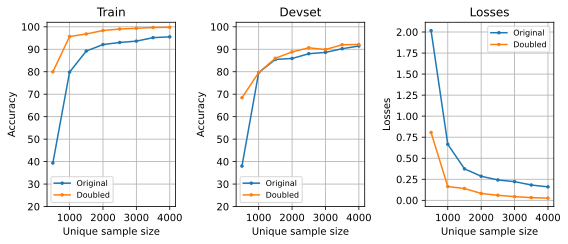

In [29]:
# Let's see what the results look like!

fig,ax = plt.subplots(1,3,figsize=(8,3.5) ,dpi = 140)

# axis and title labels
titles    = ['Train','Test','Losses']
yaxes_labels = ['Accuracy','Accuracy','Losses']

# common features
for i in range(3):

    # plot the lines
    ax[i].plot(samplesizes,resultsSingle[:,i],'o-',label='Original',markersize =2.5)
    ax[i].plot(samplesizes,resultsDouble[:,i],'o-',label='Doubled',markersize =2.5)

    # make it look nicer
    ax[i].set_ylabel(yaxes_labels[i])
    ax[i].set_title(titles[i])
    ax[i].legend(fontsize = 8)
    ax[i].set_xlabel('Unique sample size')
    ax[i].grid('on')

    if i<2:
        ax[i].set_ylim([20,102])

plt.tight_layout()
plt.show()